# Exercise 1 - Text Classification using Pretrained Embeddings

Handling tough real-world problems in Natural Language Processing (NLP) include tackling with class imbalance and the lack of availability of enough labeled data for training. Thanks to the recent advancements in deep transfer learning in NLP, we have been able to make rapid strides in not only tackling these problems but also leverage these models for diverse downstream NLP tasks.

The intent of this notebook is to look at various SOTA models in deep transfer learning for NLP with hands-on examples:

- Pre-trained word embeddings for Deep Learning Models (FastText with CNNs)
- Universal Embeddings (Sentence Encoders, NNLMs)

We will take a benchmark classification dataset and train and compare the performance of these models. All examples here will be showcased using Python and leveraging the latest and best of TensorFlow 2.x.


In [1]:
!nvidia-smi

Fri Mar 26 00:41:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Necessary Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("TF Hub version: ", hub.__version__)

TF Version:  2.4.1
Eager mode:  True
TF Hub version:  0.11.0


## Load Dataset - Hate Speech

Social media unfortunately is rampant with hate speech in the form of posts and comments. This is a practical example of perhaps building an automated hate speech detection system using NLP in the form of text classification.

In this notebook, we will leverage an open sourced collection of hate speech posts and comments.

The dataset is available here: [kaggle](https://www.kaggle.com/usharengaraju/dynamically-generated-hate-speech-dataset) which in turn has been curated from a wider [data source for hate speech](https://hatespeechdata.com/)

In [4]:
df = pd.read_csv('HateDataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40623 entries, 0 to 40622
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      40623 non-null  int64  
 1   id              40623 non-null  object 
 2   text            40623 non-null  object 
 3   label           40623 non-null  object 
 4   type            40623 non-null  object 
 5   model_wrong     26097 non-null  object 
 6   db.model_preds  26097 non-null  float64
 7   status          40623 non-null  object 
 8   round           40623 non-null  object 
 9   split           40623 non-null  object 
 10  annotator       40623 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.4+ MB


In [5]:
df = df[['text', 'label']]
df.head()

,text,label
0,It should be legal for a husband to rape his wife,hate
1,dalits are lowlife scum,hate
2,dalits are lowlives,hate
3,It was a better world when women dare not ques...,hate
4,I don't work this hard so that those immigrant...,hate


# Preparing Train and Test Datasets

In [6]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_labels, test_labels = train_test_split(df.text.values,
                                                                          df.label.values,
                                                                          test_size=0.2, random_state=42)

In [7]:
len(train_reviews), len(test_reviews)

(32498, 8125)

# Basic Text Pre-processing

We do minimal text pre-processing here since we are using deep learning models and not count-based methods. Steps include the following:

- Removing HTML characters
- Converting accented characters
- Fixing contractions
- Removing special characters

In [8]:
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4

import nltk
nltk.download('punkt')

     |████████████████████████████████| 266kB 12.9MB/s 
     |████████████████████████████████| 327kB 27.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85271 sha256=3017fc50b01e5354db7b61e6aa47416921c19a9e4dd9a4a059f50a1842893cba
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Question 1**: Build the text pre-processing pipeline

__Hint:__ You can follow the same sequence of steps like the tutorial

In [9]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [10]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

 12%|█▏        | 3951/32498 [00:00<00:03, 7938.59it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 8125/8125 [00:01<00:00, 7985.44it/s]

CPU times: user 4.75 s, sys: 390 ms, total: 5.14 s
Wall time: 5.04 s


## Label Encode Classes

# **Question 2**: Label Encode Class Labels

In [11]:
from sklearn.preprocessing import LabelEncoder
# positive -> 1, negative -> 0

le = LabelEncoder()
num_classes=2 

In [12]:
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

# __Question 3:__ Build Model 0 - Simple Baseline ML Model - Logistic Regression

## Feature Extraction with BOW Model

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(norm_train_reviews)
cv_test_features = cv.transform(norm_test_reviews)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (32498, 13077)  Test features shape: (8125, 13077)


## Train the ML Model

In [14]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, y_train)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 3.92 s, sys: 4.93 s, total: 8.85 s
Wall time: 4.56 s


## Predict and Test Model Performance

In [15]:
print(classification_report(y_test, lr_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, lr_bow_predictions))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      4401
           1       0.72      0.68      0.70      3724

    accuracy                           0.73      8125
   macro avg       0.73      0.73      0.73      8125
weighted avg       0.73      0.73      0.73      8125



,0,1
0,3416,985
1,1208,2516


___Not that great a performance! Can we do better?___

# __Question 4:__ Build Model 1: FastText Embeddings + CNN 

![](https://i.imgur.com/6Pk3Nrv.png)

Convolutional Neural Networks (CNNs) have also proven to be very effective in text classification besides computer vision tasks. The idea is to leverage embeddings as features for text data and apply convolutions and poolings on them.

We will leverage the ``tensorflow.keras`` utilities to tokenize text before we use the FastText embeddings

## Tokenizing text to create vocabulary

### Tokenize text corpus.
_Hint: Use ``tf.keras.preprocessing.text.Tokenizer``_

In [16]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

## Convert texts (sequences of words) to sequence of numeric ids

In [18]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [19]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=19098
Number of Documents=32498


## Visualizing sentence length distribution

(0.0, 2000.0)

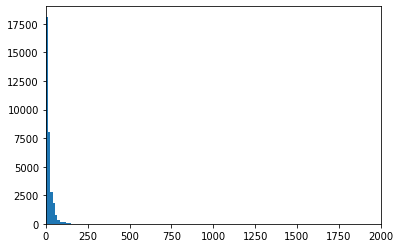

In [20]:
plt.hist([len(doc.split()) for doc in norm_train_reviews], bins=30);
plt.xlim([0, 2000])

## Padding text sequences

We standardize the sentence lengths by defining a maximum length. Sentences longer than this are truncated while shorter ones are padded.

___Use a max sequence length of around 250 based on the above histogram___

In [21]:
MAX_SEQUENCE_LENGTH = 250

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((32498, 250), (8125, 250))

## Building FastText based Embedding Matrix

Here we will build an embedding matrix based on pre-trained FastText Embeddings available __[here](https://fasttext.cc/docs/en/english-vectors.html)__.

We will be using the __wiki-news-300d-1M.vec.zip__ embedding file which has 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).

![](https://i.imgur.com/5de9N5R.png)

## Download Pre-trained FastText Embeddings

We have chosen a slightly less powerful model which should download faster than the tutorial but feel free to play around with different pretrained embeddings from [here](https://fasttext.cc/docs/en/english-vectors.html)

In [27]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2021-03-26 00:51:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  4.57MB/s    in 2m 4s   

2021-03-26 00:53:34 (5.23 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [28]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


## Generate Pre-trained Embedding Matrix

In [ ]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300

In [29]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):  
    """
    Utility function to load the pre-trained embeddings
    """  
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [30]:
# get FastText embeddings based on our word to index mapping dictionary
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(19098, 300)

## Build Model Architecture

We will use the ``tensorflow.keras`` high level API for building our deep neural network. One slight modification is required for the ``Embedding`` layer. In place of initializing this layer with random weights (as is usual), we start from FastText embeddings weights by setting the ``weights`` parameter. We also keep ``trainable`` parameter as ``True`` in order to learn/improve the pretrained weights as per our corpus. The rest of the model has usual ``Conv1D`` and ``MaxPool`` layers.

### Build a 1D-Convolution based classification model. Initialize the embedding layer with FastText weights

___You can use a similar architecture as the tutorial or build your own!___

In [75]:
# create the model
model = tf.keras.models.Sequential()

# the weights of the embedding layer are FastText weights
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 300)          5729400   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 250, 256)          307456    
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 125, 256)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 125, 128)          131200    
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 62, 64)            32832     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 31, 64)          

## Train and Validate Model

### Train the Model

Use a similar methodology as the tutorial but use the following configs also:
- __`validation_split`__ of __0.02__ i.e. 2%
- 5 epochs
- 128 batch size
- no callbacks needed to keep things simple

In [76]:
EPOCHS=5
BATCH_SIZE=128

In [77]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.02,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          verbose=1)

Epoch 1/5
249/249 [==============================] - 20s 79ms/step - loss: 0.6629 - accuracy: 0.5847 - val_loss: 0.5227 - val_accuracy: 0.7185
Epoch 2/5
249/249 [==============================] - 20s 79ms/step - loss: 0.3993 - accuracy: 0.8156 - val_loss: 0.4174 - val_accuracy: 0.7846
Epoch 3/5
249/249 [==============================] - 20s 78ms/step - loss: 0.2366 - accuracy: 0.8977 - val_loss: 0.5294 - val_accuracy: 0.7785
Epoch 4/5
249/249 [==============================] - 20s 79ms/step - loss: 0.1456 - accuracy: 0.9410 - val_loss: 0.6213 - val_accuracy: 0.7785
Epoch 5/5
249/249 [==============================] - 20s 79ms/step - loss: 0.0906 - accuracy: 0.9646 - val_loss: 0.6682 - val_accuracy: 0.7892


## Model Performance Evaluation on the Test Dataset

### Evaluate the Model

In [78]:
predictions = model.predict_classes(X_test, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 77.82%
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4401
           1       0.77      0.74      0.75      3724

    accuracy                           0.78      8125
   macro avg       0.78      0.78      0.78      8125
weighted avg       0.78      0.78      0.78      8125



,0,1
0,3564,837
1,965,2759


___Do you observe a better performance?___

# __Question 5:__ Build Model 2: Neural Network Language Model

Authors Bengio et. al. in their paper titled [A Neural Probabilistic Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) present a novel method to learn the joint probability function of sequences of
words in a language. This LM learns useful representation of sentences and words which can be leveraged for other NLP tasks such as Classication, Translation, etc.

Let us leverage NNLM embeddings to train a classifier on the hate speech dataset

![](https://i.imgur.com/blaLxUp.png)

## Prepare Datasets

In [79]:
norm_train_reviews = np.array(norm_train_reviews)
norm_test_reviews = np.array(norm_test_reviews)

## Build a NNLM Embedding Layer 

In [81]:
model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)

## Build Model Architecture

### Build a Classification Model using the TF_Hub pretrained model

___Use a similar architecture as the tutorial or try your own!___

In [82]:
model = tf.keras.models.Sequential()

model.add(hub_layer)

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 124,675,841
Trainable params: 124,675,841
Non-trainable params: 0
_______________________________________

## Train and Validate Model

Use a similar methodology as the tutorial but use the following configs also:
- __`validation_split`__ of __0.02__ i.e. 2%
- 5 epochs
- 128 batch size
- no callbacks needed to keep things simple


In [83]:
EPOCHS = 5
BATCH_SIZE=128

# Fit the model
model.fit(norm_train_reviews, y_train, 
          validation_split=0.02,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          verbose=1)

Epoch 1/5
249/249 [==============================] - 7s 26ms/step - loss: 0.6444 - accuracy: 0.6117 - val_loss: 0.5410 - val_accuracy: 0.7031
Epoch 2/5
249/249 [==============================] - 6s 25ms/step - loss: 0.4596 - accuracy: 0.7801 - val_loss: 0.5096 - val_accuracy: 0.7323
Epoch 3/5
249/249 [==============================] - 6s 25ms/step - loss: 0.3535 - accuracy: 0.8366 - val_loss: 0.5109 - val_accuracy: 0.7508
Epoch 4/5
249/249 [==============================] - 6s 25ms/step - loss: 0.2665 - accuracy: 0.8825 - val_loss: 0.5514 - val_accuracy: 0.7615
Epoch 5/5
249/249 [==============================] - 6s 25ms/step - loss: 0.2085 - accuracy: 0.9088 - val_loss: 0.6827 - val_accuracy: 0.7677


## Model Performance Evaluation on the Test Dataset

In [84]:
predictions = model.predict_classes(norm_test_reviews, 
                                    batch_size=512, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 74.60%
              precision    recall  f1-score   support

           0       0.74      0.81      0.78      4401
           1       0.75      0.67      0.71      3724

    accuracy                           0.75      8125
   macro avg       0.75      0.74      0.74      8125
weighted avg       0.75      0.75      0.74      8125



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,0,1
0,3576,825
1,1239,2485


# __Question 6:__ Build Model 3: Google's Universal Sentence Encoder

These models take as input English strings and
produce as output a fixed dimensional embedding
representation of the string.

It has two models for encoding
sentences into embedding vectors. 
- One makes use
of the transformer (Vaswani et al., 2017) architecture
- The other is formulated as a deep averaging network (DAN) (Iyyer et al., 2015)

__Methodology 1: Transformers__

- The transformer based sentence encoding model
constructs sentence embeddings using the encoding sub-graph of the transformer architecture
(Vaswani et al., 2017). 
- This sub-graph uses attention to compute context aware representations
of words in a sentence that take into account both
the ordering and identity of all the other words.
- The context aware word representations are converted to a fixed length sentence encoding vector
by computing the element-wise sum of the representations at each word position
- The encoder takes as input a lowercased (Penn TreeBank) PTB tokenized string
and outputs a 512 dimensional vector as the sentence embedding


__Methodology 2: Deep Averaging Network (DAN)__

- In the deep averaging network (DAN) (Iyyer et al.,
2015) the input embeddings for words and
bi-grams are first averaged together and then
passed through a feedforward deep neural network
(DNN) to produce sentence embeddings. 
- Similar to the Transformer encoder, the DAN encoder takes as input a lowercased PTB tokenized string and outputs a 512 dimensional sentence embedding.

__Training Methodology:__

The encoding model is designed to be as general purpose as possible. This is accomplished by using multi-task learning whereby a single encoding model is used to feed multiple downstream tasks. 

Unsupervised training data for the sentence encoding models are drawn from a variety of web sources. The sources are Wikipedia, web news,
web question-answer pages and discussion forums. We augment unsupervised learning with training on supervised data from the Stanford Natural Language Inference (SNLI) corpus.


![](https://i.imgur.com/HIeb3tY.png)

## Build a USE Embedding Layer

### Using Tensorflow hub, prepare an instance of ``hub.KerasLayer`` to get sentence embeddings

In [85]:
model = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(model, output_shape=[512], input_shape=[], 
                           dtype=tf.string, trainable=True)

## Build Model Architecture

___Use a similar architecture as the tutorial or try your own!___

In [86]:
model = tf.keras.models.Sequential()

model.add(hub_layer)

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 257       
Total params: 256,995,201
Trainable params: 256,995,201
Non-trainable params: 0
_______________________________________

## Train and Validate Model

Use a similar methodology as the tutorial but use the following configs also:
- __`validation_split`__ of __0.02__ i.e. 2%
- 5 epochs
- 128 batch size
- no callbacks needed to keep things simple

In [87]:
# Fit the model
EPOCHS=5
BATCH_SIZE=128
    
model.fit(norm_train_reviews, y_train, 
          validation_split=0.02,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          verbose=1)

Epoch 1/5
249/249 [==============================] - 24s 77ms/step - loss: 0.5868 - accuracy: 0.6756 - val_loss: 0.4660 - val_accuracy: 0.7554
Epoch 2/5
249/249 [==============================] - 19s 76ms/step - loss: 0.3154 - accuracy: 0.8544 - val_loss: 0.4352 - val_accuracy: 0.7600
Epoch 3/5
249/249 [==============================] - 19s 77ms/step - loss: 0.1654 - accuracy: 0.9302 - val_loss: 0.6532 - val_accuracy: 0.7769
Epoch 4/5
249/249 [==============================] - 19s 76ms/step - loss: 0.0890 - accuracy: 0.9640 - val_loss: 0.7496 - val_accuracy: 0.7738
Epoch 5/5
249/249 [==============================] - 19s 75ms/step - loss: 0.0584 - accuracy: 0.9762 - val_loss: 0.7934 - val_accuracy: 0.7862


## Model Performance Evaluation on the Test Dataset

### **Question 9**: Get Evaluation Results of the model

In [88]:
predictions = model.predict_classes(test_reviews, batch_size=512, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 73.75%
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      4401
           1       0.72      0.69      0.71      3724

    accuracy                           0.74      8125
   macro avg       0.74      0.73      0.73      8125
weighted avg       0.74      0.74      0.74      8125



,0,1
0,3422,979
1,1154,2570
